In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%load_ext autoreload
%autoreload 2
import copy
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# from learning_wavelets.data import im_generators, ConcatenateGenerators
from learning_wavelets.datasets import im_dataset_bsd68
from learning_wavelets.dncnn import dncnn
from learning_wavelets.keras_utils.thresholding import SoftThresholding, HardThresholding, DynamicSoftThresholding, DynamicHardThresholding, RelaxedDynamicHardThresholding, LocalWienerFiltering
from learning_wavelets.learned_wavelet import learned_wavelet, learnlet
from learning_wavelets.unet import unet
from learning_wavelets.utils.metrics import metrics_from_ds, metrics_original_from_ds
# from learning_wavelets.utils.metrics import metrics_for_params, metrics_exact_recon_net, metrics_original, metrics_wavelets, metrics_bm3d, metrics_dynamic_denoising_net


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.4.1     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [4]:
np.random.seed(0)

In [5]:
all_net_params = [
#     {
#         'name': 'unet_0_55',
#         'init_function': unet,
#         'run_params': {
#             'n_layers': 5, 
#             'pool': 'max', 
#             "layers_n_channels": [64, 128, 256, 512, 1024], 
#             'layers_n_non_lins': 2,
#             'non_relu_contract': False,
#             'bn': True,
#             'input_size': (None, None, 1),
#         },
#         'run_id': 'unet_dynamic_st_bsd500_0_55_1576668365',
#         'epoch': 500,
#     },
#     {
#         'name': 'unet_20_40',
#         'init_function': unet,
#         'run_params': {
#             'n_layers': 5, 
#             'pool': 'max', 
#             "layers_n_channels": [64, 128, 256, 512, 1024], 
#             'layers_n_non_lins': 2,
#             'non_relu_contract': False,
#             'bn': True,
#             'input_size': (None, None, 1),
#         },
#         'run_id': 'unet_dynamic_st_bsd500_20.0_40.0_1581002329',
#         'epoch': 500,
#     },
#     {
#         'name': 'unet_30',
#         'init_function': unet,
#         'run_params': {
#             'n_layers': 5, 
#             'pool': 'max', 
#             "layers_n_channels": [64, 128, 256, 512, 1024], 
#             'layers_n_non_lins': 2,
#             'non_relu_contract': False,
#             'bn': True,
#             'input_size': (None, None, 1),
#         },
#         'run_id': 'unet_dynamic_st_bsd500_30.0_30.0_1581002329',
#         'epoch': 500,
#     },
]

dynamic_denoising_net_params = [
    {
        'name': 'learnlet_0_55_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_0_55_1580806694',
        'epoch': 500,
    },
    {
        'name': 'learnlet_0_55_decreasing_n_lvl',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_256_dynamic_soft_thresholding_bsd500_decreasing_1581584676',
        'epoch': 500,
    },
#     {
#         'name': 'learnlet_20_40_big_bsd',
#         'init_function': learnlet,
#         'run_params': {
#             'denoising_activation': 'dynamic_soft_thresholding',
#             'learnlet_analysis_kwargs':{
#                 'n_tiling': 256, 
#                 'mixing_details': False,  
#                 'kernel_size': 11,
#                 'skip_connection': True,
#             },
#             'learnlet_synthesis_kwargs': {
#                 'res': True,
#                 'kernel_size': 13,
#             },
#             'n_scales': 5,
#             'exact_reconstruction_weight': 0,
#             'clip': True,
#             'input_size': (None, None, 1),     
#         },
#         'run_id': 'learnlet_dynamic_st_bsd500_20_40_1580492805',
#         'epoch': 500,
#     },
#     {
#         'name': 'learnlet_30_big_bsd',
#         'init_function': learnlet,
#         'run_params': {
#             'denoising_activation': 'dynamic_soft_thresholding',
#             'learnlet_analysis_kwargs':{
#                 'n_tiling': 256, 
#                 'mixing_details': False,  
#                 'kernel_size': 11,
#                 'skip_connection': True,
#             },
#             'learnlet_synthesis_kwargs': {
#                 'res': True,
#                 'kernel_size': 13,
#             },
#             'n_scales': 5,
#             'exact_reconstruction_weight': 0,
#             'clip': True,
#             'input_size': (None, None, 1),     
#         },
#         'run_id': 'learnlet_dynamic_st_bsd500_30_1580668579',
#         'epoch': 500,
#     },
]

In [6]:
noise_stds = [0.0001, 5, 15, 20, 25, 30, 50, 75]
# noise_stds = [15, 20, 30]
# noise_stds = [0.0001]

In [7]:
noise_std_metrics = {}
n_samples = None
for noise_std in tqdm_notebook(noise_stds, 'Noise stds'):
    metrics = []
    for net_params in all_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=False,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))
    im_ds = im_dataset_bsd68(
        mode='testing', 
        batch_size=1, 
        patch_size=None, 
        noise_std=noise_std, 
        return_noise_level=False,
        n_pooling=5,
        n_samples=n_samples,
    )
    metrics.append(('original', metrics_original_from_ds(im_ds)))
        
    for net_params in dynamic_denoising_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))

#     metrics.append(('bm3d', metrics_bm3d(im_gen_test)))
#     metrics.append(('wavelets_24', metrics_wavelets(im_gen_test, '24', noise_std=noise_std)))
#     metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())
    noise_std_metrics[noise_std] = metrics

/volatile/home/Zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=1)
/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:43: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt, pred, multichannel=True, data_range=1


In [8]:
noise_std_metrics

{0.0001: [('original', PSNR = 128.1 +/- 0.03673 SSIM = 1 +/- 5.808e-11),
  ('learnlet_0_55_big_bsd', PSNR = 43.76 +/- 7.204 SSIM = 0.9959 +/- 0.00322),
  ('learnlet_0_55_decreasing_n_lvl',
   PSNR = 49.54 +/- 6.972 SSIM = 0.9986 +/- 0.0009801)],
 5: [('original', PSNR = 34.15 +/- 0.02796 SSIM = 0.8855 +/- 0.102),
  ('learnlet_0_55_big_bsd', PSNR = 36.38 +/- 4.074 SSIM = 0.9569 +/- 0.03055),
  ('learnlet_0_55_decreasing_n_lvl',
   PSNR = 36.89 +/- 3.765 SSIM = 0.9593 +/- 0.02913)],
 15: [('original', PSNR = 24.61 +/- 0.03432 SSIM = 0.569 +/- 0.2582),
  ('learnlet_0_55_big_bsd', PSNR = 30.84 +/- 4.738 SSIM = 0.8588 +/- 0.09551),
  ('learnlet_0_55_decreasing_n_lvl',
   PSNR = 30.93 +/- 4.592 SSIM = 0.8595 +/- 0.0908)],
 20: [('original', PSNR = 22.11 +/- 0.03832 SSIM = 0.4664 +/- 0.2662),
  ('learnlet_0_55_big_bsd', PSNR = 29.48 +/- 4.851 SSIM = 0.8153 +/- 0.1103),
  ('learnlet_0_55_decreasing_n_lvl',
   PSNR = 29.52 +/- 4.685 SSIM = 0.8142 +/- 0.1058)],
 25: [('original', PSNR = 20.17 +/

In [9]:
BM3D_psnr_results = {
    5: 37.57,
    15: 31.07,
    20: 29.60,
    25: 28.57,
    30: 27.74,
    50: 25.62,
    75: 24.21,
}

wavelets_psnr_results = {
    5: (35.76,  1.937),
    15: (29.56,  2.553),
    20: (28.25,  2.645),
    25: (27.32,  2.684),
    30: (26.61,  2.694),
    50: (24.79,  2.673),
    75: (23.46,  2.574),
}

In [10]:
# PSNR table
psnr_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    psnr_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        psnr_metrics_table.loc[i, name] = "{mean:.4} ({std:.2})".format(
            mean=m.metrics['PSNR'].mean(), 
            std=m.metrics['PSNR'].stddev(),
        )
#     psnr_metrics_table.loc[i, 'bm3d'] = BM3D_psnr_results[noise_std]
#     psnr_metrics_table.loc[i, 'wavelets_24'] = "{mean:.4} ({std:.2})".format(
#         mean=wavelets_psnr_results[noise_std][0], 
#         std=wavelets_psnr_results[noise_std][1],
#     )
psnr_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_decreasing_n_lvl,original,wavelets_24,bm3d
0,0.0001,43.76 (3.6),49.54 (3.5),128.1 (0.018),NaN,NaN
1,5,36.38 (2.0),36.89 (1.9),34.15 (0.014),NaN,NaN
2,15,30.84 (2.4),30.93 (2.3),24.61 (0.017),NaN,NaN
3,20,29.48 (2.4),29.52 (2.3),22.11 (0.019),NaN,NaN
4,25,28.46 (2.4),28.45 (2.4),20.17 (0.015),NaN,NaN
5,30,27.66 (2.5),27.61 (2.4),18.59 (0.015),NaN,NaN
6,50,25.48 (2.4),25.31 (2.2),14.15 (0.02),NaN,NaN
7,75,23.78 (2.2),23.51 (2.0),10.63 (0.015),NaN,NaN


In [11]:
# SSIM table
ssim_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    ssim_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        ssim_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['SSIM'].mean(), 
            std=m.metrics['SSIM'].stddev(),
        )
ssim_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_decreasing_n_lvl,original,wavelets_24,bm3d
0,0.0001,0.9959 (0.00161),0.9986 (0.00049),1.0 (2.904e-11),NaN,NaN
1,5,0.9569 (0.01528),0.9593 (0.01457),0.8855 (0.05099),NaN,NaN
2,15,0.8588 (0.04775),0.8595 (0.0454),0.569 (0.1291),NaN,NaN
3,20,0.8153 (0.05517),0.8142 (0.05289),0.4664 (0.1331),NaN,NaN
4,25,0.7758 (0.05992),0.7721 (0.05674),0.3881 (0.1282),NaN,NaN
5,30,0.7396 (0.06272),0.7335 (0.05908),0.3279 (0.1201),NaN,NaN
6,50,0.619 (0.06835),0.6038 (0.0608),0.1834 (0.08356),NaN,NaN
7,75,0.5062 (0.06381),0.483 (0.0574),0.1012 (0.05167),NaN,NaN


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize': (9, 5), 'image.cmap': 'gray'})

In [17]:
relative_to_original = True

model_family_str = r'$\bf{Model}$'
noise_std_str = 'Test noise standard deviation'
psnr_str = 'Ratio over original PSNR'
# PSNR to plot
psnr_to_plot = pd.DataFrame(
    columns=[noise_std_str, psnr_str, 'psnr-std-dev', 'model_name', model_family_str]
)

def from_name_to_family(model_name):
    if 'learnlet' in model_name:
        return 'Learnlets'
    elif 'unet' in model_name:
        return 'U-net'
    elif 'bm3d' in model_name:
        return 'BM3D'
    elif 'wavelets' in model_name:
        return 'Wavelets'
    else:
        return 'Original'
    
def from_name_to_decreasing(model_name):
    return 'decreasing' in model_name

family_model_to_color = {
    'U-net': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
    'Learnlets': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'LearnletsFalse': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'LearnletsTrue': 'red',
    'BM3D': 'violet',
    'Wavelets': 'red',
    'Original': (0.41568627450980394, 0.8, 0.39215686274509803),
}
index = 0
orig_psnrs = {}
for i_noise, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    for j_model, (name, m) in enumerate(metrics):
        if relative_to_original and name == 'original':
            orig_psnrs[noise_std] = m.metrics['PSNR'].mean()
        else:
            psnr_to_plot.loc[index, noise_std_str] = noise_std
            psnr_to_plot.loc[index, psnr_str] = m.metrics['PSNR'].mean()
            psnr_to_plot.loc[index, 'psnr-std-dev'] = m.metrics['PSNR'].stddev() / 2
            psnr_to_plot.loc[index, 'model_name'] = name
            psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name) + str(from_name_to_decreasing(name))
            index += 1
#     name = 'bm3d'
#     psnr_to_plot.loc[index, noise_std_str] = noise_std
#     psnr_to_plot.loc[index, psnr_str] = BM3D_psnr_results[noise_std]
#     psnr_to_plot.loc[index, 'psnr-std-dev'] = 0
#     psnr_to_plot.loc[index, 'model_name'] = name
#     psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
#     psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
#     index += 1
#     name = 'wavelets_24'
#     psnr_to_plot.loc[index, noise_std_str] = noise_std
#     psnr_to_plot.loc[index, psnr_str] = wavelets_psnr_results[noise_std][0]
#     psnr_to_plot.loc[index, 'psnr-std-dev'] = wavelets_psnr_results[noise_std][1]
#     psnr_to_plot.loc[index, 'model_name'] = name
#     psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
#     psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
#     index += 1
    

if relative_to_original:
    for noise_std, orig_psnr in orig_psnrs.items():
        psnr_to_plot.loc[psnr_to_plot[noise_std_str] == noise_std, psnr_str] = psnr_to_plot[psnr_to_plot[noise_std_str] == noise_std][psnr_str] / orig_psnr
    
psnr_to_plot

,Test noise standard deviation,Ratio over original PSNR,psnr-std-dev,model_name,$\bf{Model}$
0,0.0001,0.341557,1.80104,learnlet_0_55_big_bsd,LearnletsFalse
1,0.0001,0.386657,1.74308,learnlet_0_55_decreasing_n_lvl,LearnletsTrue
2,5,1.06532,1.01849,learnlet_0_55_big_bsd,LearnletsFalse
3,5,1.08026,0.941162,learnlet_0_55_decreasing_n_lvl,LearnletsTrue
4,15,1.25294,1.18449,learnlet_0_55_big_bsd,LearnletsFalse
5,15,1.25685,1.148,learnlet_0_55_decreasing_n_lvl,LearnletsTrue
6,20,1.33318,1.21266,learnlet_0_55_big_bsd,LearnletsFalse
7,20,1.33468,1.1712,learnlet_0_55_decreasing_n_lvl,LearnletsTrue
8,25,1.4112,1.2231,learnlet_0_55_big_bsd,LearnletsFalse
9,25,1.41055,1.18356,learnlet_0_55_decreasing_n_lvl,LearnletsTrue


In [18]:
# plt.figure()
# psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
# lplot = sns.lineplot(
#     x=noise_std_str, 
#     y=psnr_str, 
#     hue=model_family_str,
#     style=train_stds_str,
#     data=psnr_to_plot,
#     palette=family_model_to_color,
# )
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
# plt.subplots_adjust(right=0.83)
# plt.savefig(f'gen.png')

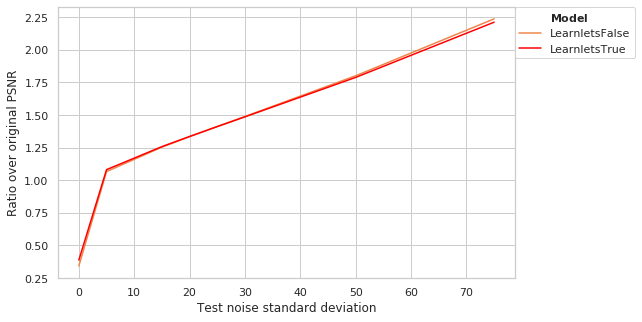

In [19]:
plt.figure()
psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
lplot = sns.lineplot(
    x=noise_std_str, 
    y=psnr_str, 
    hue=model_family_str,
    data=psnr_to_plot,
    palette=family_model_to_color,
)
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
plt.subplots_adjust(right=0.83)
plt.savefig(f'gen_wo_error_bars.png')